## 0. Loading Packages

In [8]:
import pandas as pd
import numpy as np
from scipy.stats import ks_2samp
import git
from pathlib import Path
import warnings
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import tempfile
import shutil
ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from transform_audio import *
warnings.filterwarnings("ignore", category=UserWarning, module='numpy.lib.npyio')

## 1. Select transform type and group

In [9]:
groups = {3: ['normal_intensity', 'strong_intensity'], 4: ['statement_1', 'statement_2'], 6: ['male', 'female']}
group = 6
categories = {3: 'emotional intensity', 4: 'statement', 6: 'gender'}

CATEGORY_NAME = categories[group]
GROUP_NAMES = groups[group]

# Suffix used to construct internal filenames
transform_affix = 'fft'

DATA = 'ravdess'

# --- Path Definitions ---
DATA_DIR = os.path.join(ROOT_DIR, 'raw-data', DATA, DATA + '-transforms')

NORMALIZE = 0 # 1 for pitch normalization, 0 for no pitch normalization

GEOMETRIC = 1  # 1 for geometric + raw bands, 0 for raw bands only

VISUALIZE_RESULTS = 1 # 1 to visualize results, 0 to skip visualization
VISUALIZE_GEOMETRIC_BANDS = 0 # 1 to visualize geometric bands, 0 to skip visualization

# freq_band_groupings parameters
KS_THRESHOLD = 0.05  
BATCH_SIZE = None
SUBSAMPLE_EVERY = 1
PRESPLIT_DEPTH = 1

if NORMALIZE == 1:
    experiment_key = "Pitch-Normalized"
    file_suffix = f"{transform_affix}-pn"
else:
    experiment_key = "Original-Pitch"
    file_suffix = f"{transform_affix}"


PATHS = {
    experiment_key: {
        "coefs_path": os.path.join(DATA_DIR, f'{file_suffix}_coefs.npz'),
        "freqs_path": os.path.join(DATA_DIR, f'{file_suffix}_freqs.npy')
    }
}

print(f"Analysis Category: {CATEGORY_NAME.replace('_', ' ').title()} ({GROUP_NAMES[0]} vs {GROUP_NAMES[1]})")
print(f"KS Test Decision Threshold: {KS_THRESHOLD}")

Analysis Category: Gender (male vs female)
KS Test Decision Threshold: 0.05


## 2. Distribution Analysis

In [10]:
all_results = {}
all_files_exist = True

for experiment_name, paths in PATHS.items():
    print(f"\n{experiment_name}")

    temp_dir_path = Path(tempfile.mkdtemp())
    print(f"  - Created temporary directory: {temp_dir_path}")

    try:
        unified_band_indices = freq_band_groupings(
            coefs_npz_path=paths["coefs_path"],
            ks_threshold=KS_THRESHOLD,
            batch_size=BATCH_SIZE,
            subsample_every=SUBSAMPLE_EVERY,
            presplit_depth=PRESPLIT_DEPTH
        )
        print(f"Found {len(unified_band_indices)} bands.")
        
        preprocess_and_save_by_band(
            coefs_npz_path=paths["coefs_path"],
            unified_bands_indices=unified_band_indices,
            temp_dir=temp_dir_path,
            group_id=group,
            group_map=groups
        )

        comparison_df = compare_distributions_from_files(
            temp_dir=temp_dir_path,
            unified_bands_indices=unified_band_indices,
            group_names=GROUP_NAMES
        )
        
        all_results[experiment_name] = comparison_df
    finally:
        print(f"  - Cleaning up temporary directory: {temp_dir_path}")
        shutil.rmtree(temp_dir_path)

    print(f"{experiment_name} complete.")

print("\n\n--- All Experiments Finished ---")


Original-Pitch
  - Created temporary directory: /var/folders/73/sgjz9s7d6b318g3bz68k4lnr0000gn/T/tmp33z3t0ih
Found 31 bands.
  Pre-processing and sharding data by band to: /var/folders/73/sgjz9s7d6b318g3bz68k4lnr0000gn/T/tmp33z3t0ih
  - Found 1440 files in NPZ archive. Starting sharding...
    - Sharding file 1000/1440...
  Performing KS test band by band from sharded files...
  - Cleaning up temporary directory: /var/folders/73/sgjz9s7d6b318g3bz68k4lnr0000gn/T/tmp33z3t0ih
Original-Pitch complete.


--- All Experiments Finished ---


## 3. Band Visualization

### Analysis Report: Gender ###
--- Results for: Original-Pitch (male vs female) ---
In 31 bands, 17 have a difference greater than the threshold 0.05.
band_indices  ks_stat_real  ks_stat_imag
           0         0.189         0.000
           1         0.139         0.138
           2         0.072         0.168
           3         0.097         0.074
         4-8         0.038         0.084
        9-18         0.045         0.048
       19-28         0.051         0.055
       29-38         0.049         0.058
       39-57         0.042         0.042
       58-77         0.029         0.029
      78-116         0.024         0.023
     117-155         0.033         0.030
     156-312         0.114         0.119
     313-468         0.295         0.295
     469-546         0.257         0.256
     547-625         0.144         0.141
    626-1251         0.047         0.048
   1252-1877         0.025         0.024
   1878-2503         0.014         0.014
   2504-5007         0.046  

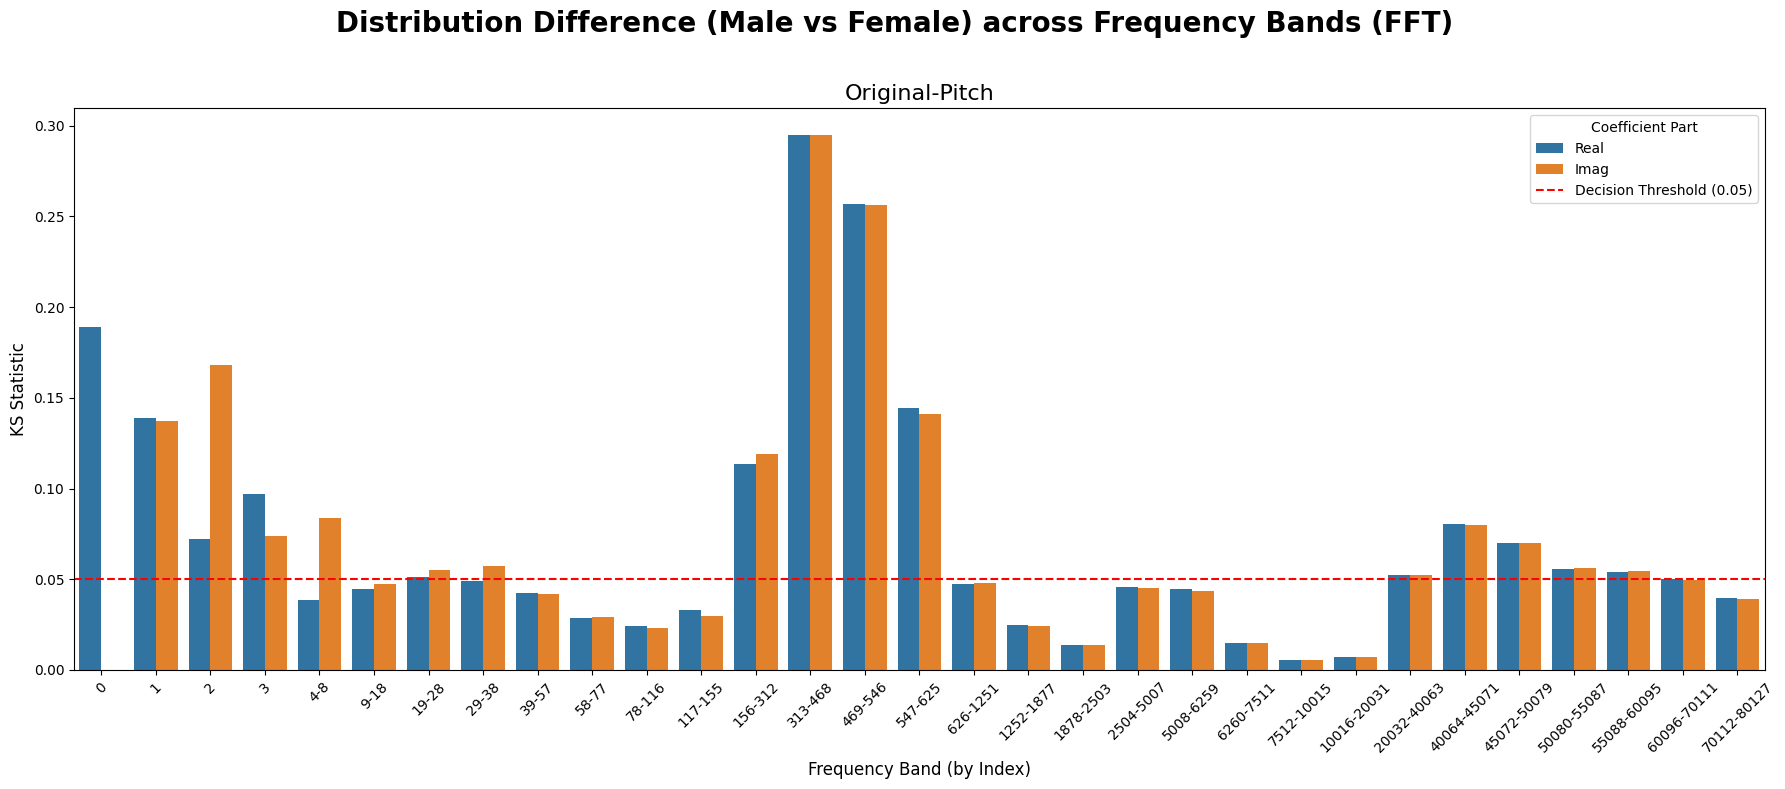

In [11]:
if VISUALIZE_RESULTS == 1:
    print(f"### Analysis Report: {CATEGORY_NAME.replace('_', ' ').title()} ###")
    
    for experiment_name, result_df in all_results.items():
        print(f"--- Results for: {experiment_name} ({GROUP_NAMES[0]} vs {GROUP_NAMES[1]}) ---")

        significant_diffs = result_df[
            (result_df['ks_stat_real'] > KS_THRESHOLD) | 
            (result_df['ks_stat_imag'] > KS_THRESHOLD)
        ]
        print(f"In {len(result_df)} bands, {len(significant_diffs)} have a difference greater than the threshold {KS_THRESHOLD}.")
        print(result_df.round(3).to_string(index=False))
        print("\n")

    # --- Visualization Plotting ---
    # Only verify experiments that actually have data
    valid_experiments = {k: v for k, v in all_results.items() if not v.empty}
    
    if valid_experiments:
        fig, axes = plt.subplots(len(valid_experiments), 1, figsize=(18, 8 * len(valid_experiments)), sharex=False)
        # Ensure axes is iterable even if there's only 1 plot
        if len(valid_experiments) == 1: axes = [axes]
        
        fig.suptitle(f'Distribution Difference ({GROUP_NAMES[0].title()} vs {GROUP_NAMES[1].title()}) across Frequency Bands ({transform_affix.upper()})', fontsize=20, weight='bold')

        for ax, (experiment_name, result_df) in zip(axes, valid_experiments.items()):
            plot_df = result_df.melt(
                id_vars=['band_indices'], 
                value_vars=['ks_stat_real', 'ks_stat_imag'],
                var_name='Coefficient Part',
                value_name='KS Statistic'
            )
            plot_df['Coefficient Part'] = plot_df['Coefficient Part'].str.replace('ks_stat_', '').str.title()
            
            sns.barplot(ax=ax, data=plot_df, x='band_indices', y='KS Statistic', hue='Coefficient Part')
            ax.axhline(y=KS_THRESHOLD, color='r', linestyle='--', label=f'Decision Threshold ({KS_THRESHOLD})')
            
            ax.set_title(experiment_name, fontsize=16)
            ax.set_xlabel('Frequency Band (by Index)', fontsize=12)
            ax.set_ylabel('KS Statistic', fontsize=12)
            ax.tick_params(axis='x', rotation=45)
            ax.legend(title='Coefficient Part')

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

## 5. Raw

In [12]:
all_subdivided_data = {}
all_files_exist = True

RAW_OUTPUT_DIR = os.path.join(ROOT_DIR, "transformed-data-audio", DATA, "raw-transformed-data")
os.makedirs(RAW_OUTPUT_DIR, exist_ok=True)

for experiment_name, paths in PATHS.items():
    print(f"\n{'='*20} Starting Experiment: {experiment_name} {'='*20}")
    
    for group_name in GROUP_NAMES: # For example: first loop group_name = 'male', second = 'female'
        print(f"\n--- Processing group: {group_name} ---")
        
        single_group_data = load_single_group_by_band(
            coefs_npz_path=paths["coefs_path"],
            unified_bands_indices=unified_band_indices,
            group_id=group,
            group_map=groups,
            category_map=categories,
            target_group=group_name
        )
        
        file_name = f'ravdess_{experiment_name}_{transform_affix}_{CATEGORY_NAME.replace(" ", "_")}_{group_name}.pickle'
        output_filename = os.path.join(RAW_OUTPUT_DIR, file_name)
        print(f"  - Saving data for '{group_name}' to: {output_filename} ...")

        # Save the Pickle file for the current group
        with open(output_filename, 'wb') as file:
            final_output_structure = {
                experiment_name: single_group_data
            }
            pickle.dump(final_output_structure, file)

        print(f"Data for group '{group_name}' saved!")


==================== Starting Experiment: Original-Pitch ====================

--- Processing group: male ---
  - Loading data for target group 'male' from: fft_coefs.npz
  - 1440 files, collecting for 'male'...
    - Found and processed 200 files for 'male'...
    - Found and processed 400 files for 'male'...
    - Found and processed 600 files for 'male'...
  - Data collection complete for 'male'. Converting lists to NumPy arrays...
  - Saving data for 'male' to: /Users/jiaxin/Documents/Summer 2025/hierarchical-bayesian-model-validation/transformed-data-audio/ravdess/raw-transformed-data/ravdess_Original-Pitch_fft_gender_male.pickle ...
Data for group 'male' saved!

--- Processing group: female ---
  - Loading data for target group 'female' from: fft_coefs.npz
  - 1440 files, collecting for 'female'...
    - Found and processed 200 files for 'female'...
    - Found and processed 400 files for 'female'...
    - Found and processed 600 files for 'female'...
  - Data collection complet

## 5. Geometric

In [13]:
if GEOMETRIC == 1:
    def visualize_bands(bands, title=""):
        plt.figure(figsize=(12, 2))
        colors = ['lightcoral', 'indianred']
        
        # Check if bands list is not empty
        if not bands:
            print(f"Warning: Cannot visualize bands for '{title}' because the band list is empty.")
            return

        for i, (start, end) in enumerate(bands):
            plt.broken_barh([(start, end - start)], (0, 1), facecolors=colors[i%2])
        
        plt.xlabel('Frequency Index')
        plt.ylabel('Bands')
        plt.title(title)
        plt.yticks([])
        plt.grid(axis='x', linestyle='--', alpha=0.6)
        plt.show()


Original-Pitch
  - Regularizing bands to a geometric scale...


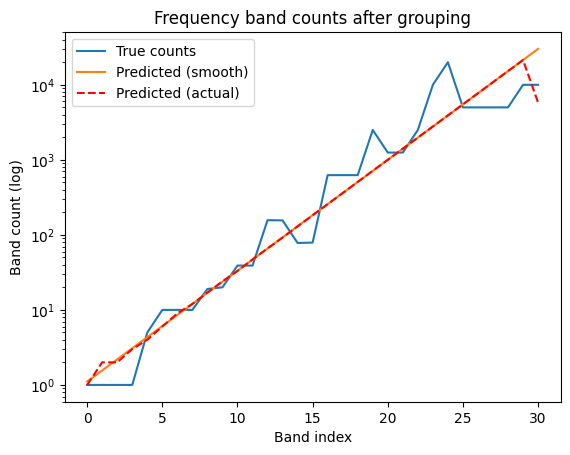

  - New band count: 31

--- Processing group: male ---
  - Loading data for target group 'male' from: fft_coefs.npz
  - 1440 files, collecting for 'male'...
    - Found and processed 200 files for 'male'...
    - Found and processed 400 files for 'male'...
    - Found and processed 600 files for 'male'...
  - Data collection complete for 'male'. Converting lists to NumPy arrays...
Data for group 'male' saved!

--- Processing group: female ---
  - Loading data for target group 'female' from: fft_coefs.npz
  - 1440 files, collecting for 'female'...
    - Found and processed 200 files for 'female'...
    - Found and processed 400 files for 'female'...
    - Found and processed 600 files for 'female'...
  - Data collection complete for 'female'. Converting lists to NumPy arrays...
Data for group 'female' saved!


In [14]:
if GEOMETRIC == 1:
    all_subdivided_data = {}
    all_files_exist = True

    GEO_OUTPUT_DIR = os.path.join(ROOT_DIR, "transformed-data-audio", DATA, "geometric-transformed-data")
    os.makedirs(GEO_OUTPUT_DIR, exist_ok=True)

    for experiment_name, paths in PATHS.items():
        print(f"\n{experiment_name}")
        print("  - Regularizing bands to a geometric scale...")
        freqs_data = np.load(paths["freqs_path"]) 
        geometric_bands = geometric_count_bands(unified_band_indices, visualize=True)
        print(f"  - New band count: {len(geometric_bands)}")

        if VISUALIZE_GEOMETRIC_BANDS == 1:
            # Visualize the ORIGINAL bands
            visualize_bands(unified_band_indices, title="Raw Bands")
            
            # Visualize the FINAL geometric bands
            visualize_bands(geometric_bands, title="Geometric Bands")

        for group_name in GROUP_NAMES:
            print(f"\n--- Processing group: {group_name} ---")
            
            single_group_data = load_single_group_by_band(
                coefs_npz_path=paths["coefs_path"],
                unified_bands_indices=geometric_bands,
                group_id=group,
                group_map=groups,
                category_map=categories,
                target_group=group_name
            )
        
            file_name = f'ravdess_{experiment_name}_{transform_affix}_{CATEGORY_NAME.replace(" ", "_")}_{group_name}_geometric.pickle'
            output_filename = os.path.join(GEO_OUTPUT_DIR, file_name)

            with open(output_filename, 'wb') as file:
                final_output_structure = {
                    experiment_name: single_group_data
                }
                pickle.dump(final_output_structure, file)

            print(f"Data for group '{group_name}' saved!")
